16.32 - Redes Neuronales en Bioingenería, ITBA
# TP3 - Segmentation Model
André Torvestad - November 2022

This notebook serves as an addition to "RN_TP3_Main.ipynb", where the changes from the updated version of "segmentation.ipynb", "segmentation_pneumo.ipynb", have been tested. 







## Data Processing

Data will be downloaded through Kaggle API. 

In [1]:
import pandas as pd

from PIL import Image
from IPython.display import clear_output 
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import json
import tensorflow as tf




In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"andrtorvestad","key":"47282d1bc85069a6c322ca5494676cc9"}
with open('/root/.kaggle/kaggle.json','w') as file:
  json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
%%time
# download using api
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks
# unzip the downloaded file
!unzip pneumothorax-chest-xray-images-and-masks.zip

clear_output()

CPU times: user 1.71 s, sys: 281 ms, total: 1.99 s
Wall time: 1min 33s


The data is now downloaded and available. 

In [4]:
test_csv = pd.read_csv('/content/siim-acr-pneumothorax/stage_1_test_images.csv')
train_csv = pd.read_csv('/content/siim-acr-pneumothorax/stage_1_train_images.csv')

With the new file, transform is set to False. 

A new version of the datagenerator is used. In order to reduce the size of the dataset, because of time used to train the models, the prefix "10*" has been added to the path to only use 1000 samples. Using all of the dataset resulted in estimated time per epoch to be 35 minutes. 

In [30]:


transform = False

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(128,128), train=True,n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        if train:
            self.filenames = [file.name for file in Path(path).glob("png_images/10*train*1_.png")]
        else:
            self.filenames = [file.name for file in Path(path).glob("png_images/*test*1_.png")]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transform(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

In [6]:
path = '/content/siim-acr-pneumothorax/'
image_prefix = 'png_images/'
mask_prefix = 'png_masks/'

Generate the datasets. This is new from the last file. A much larger batch size is used in this than before, but still just 32 has been tried out. 

In [31]:
%%time

BATCH_SIZE = 32

datagen = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = transform,
    batch_size = BATCH_SIZE,
    train = True  
)

datagen_val = DataGenerator(
    'siim-acr-pneumothorax/',
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = BATCH_SIZE,
    train = False,   
)

CPU times: user 22.6 ms, sys: 6.01 ms, total: 28.6 ms
Wall time: 32.3 ms


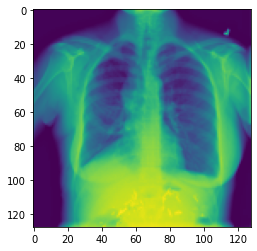

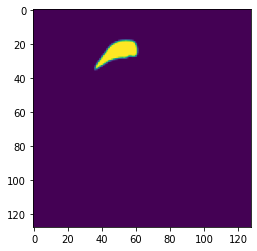

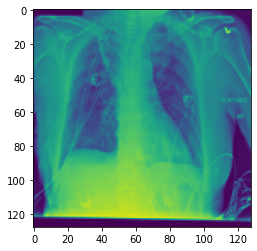

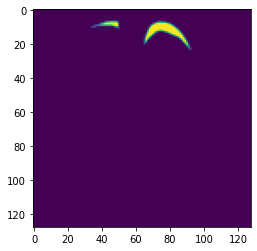

In [11]:
for idx in range(2):
    plt.imshow(datagen[0][0][idx].reshape(128,128))
    plt.show()
    plt.imshow(datagen[0][1][idx].reshape(128,128))
    plt.show()

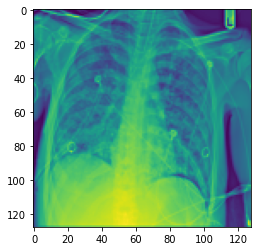

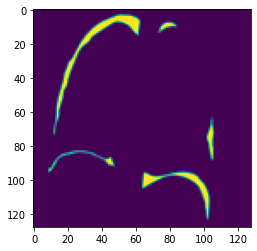

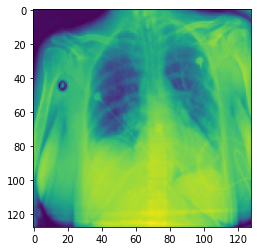

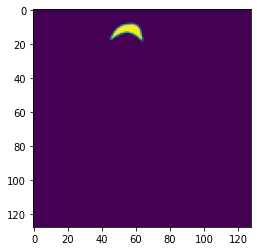

In [14]:
for idx in range(2):
    plt.imshow(datagen_val[0][0][idx].reshape(128,128))
    plt.show()
    plt.imshow(datagen_val[0][1][idx].reshape(128,128))
    plt.show()

We see that the datasets images are as expected. 

## Model Architecture Development

Create a base architecture to be used for further experimenting. The part is based on the architecture found in 'segmentation.ipynb', as given in class. 

In [15]:
# Import libraries
from PIL import Image
import numpy as np
import albumentations as A

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from keras.utils.vis_utils import plot_model

Define functions for building the U-Net architecture. Taken from 'segmentation_pneumo.ipynb'. 

In [16]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

Define the evaluation metric, DICE coeffient, and loss function. The new, updated functions are used. 

In [17]:
# definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

### Create first model

This model is equal to the model demonstrated in segmentation_pneumo.ipynb, the updated file given in the course. 

In [32]:
model = UNet((128,128,1),start_ch=32,depth=3,batchnorm=False, residual = True,dropout=False)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_74 (Conv2D)             (None, 128, 128, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_75 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_74[0][0]']              
                                )                                                           

In addition to the summary, a plot of the model is shown below to further increase the understanding of how the model works. In the picture one can clearly see how the encoder and decoder works, as one can see all operations performed. Another interesting aspect is to see how the skip connections work. The various layers in the encoder part send output to the corresponding decoder layer - a core functionality of why the U-Net architecture works as well as it does. 

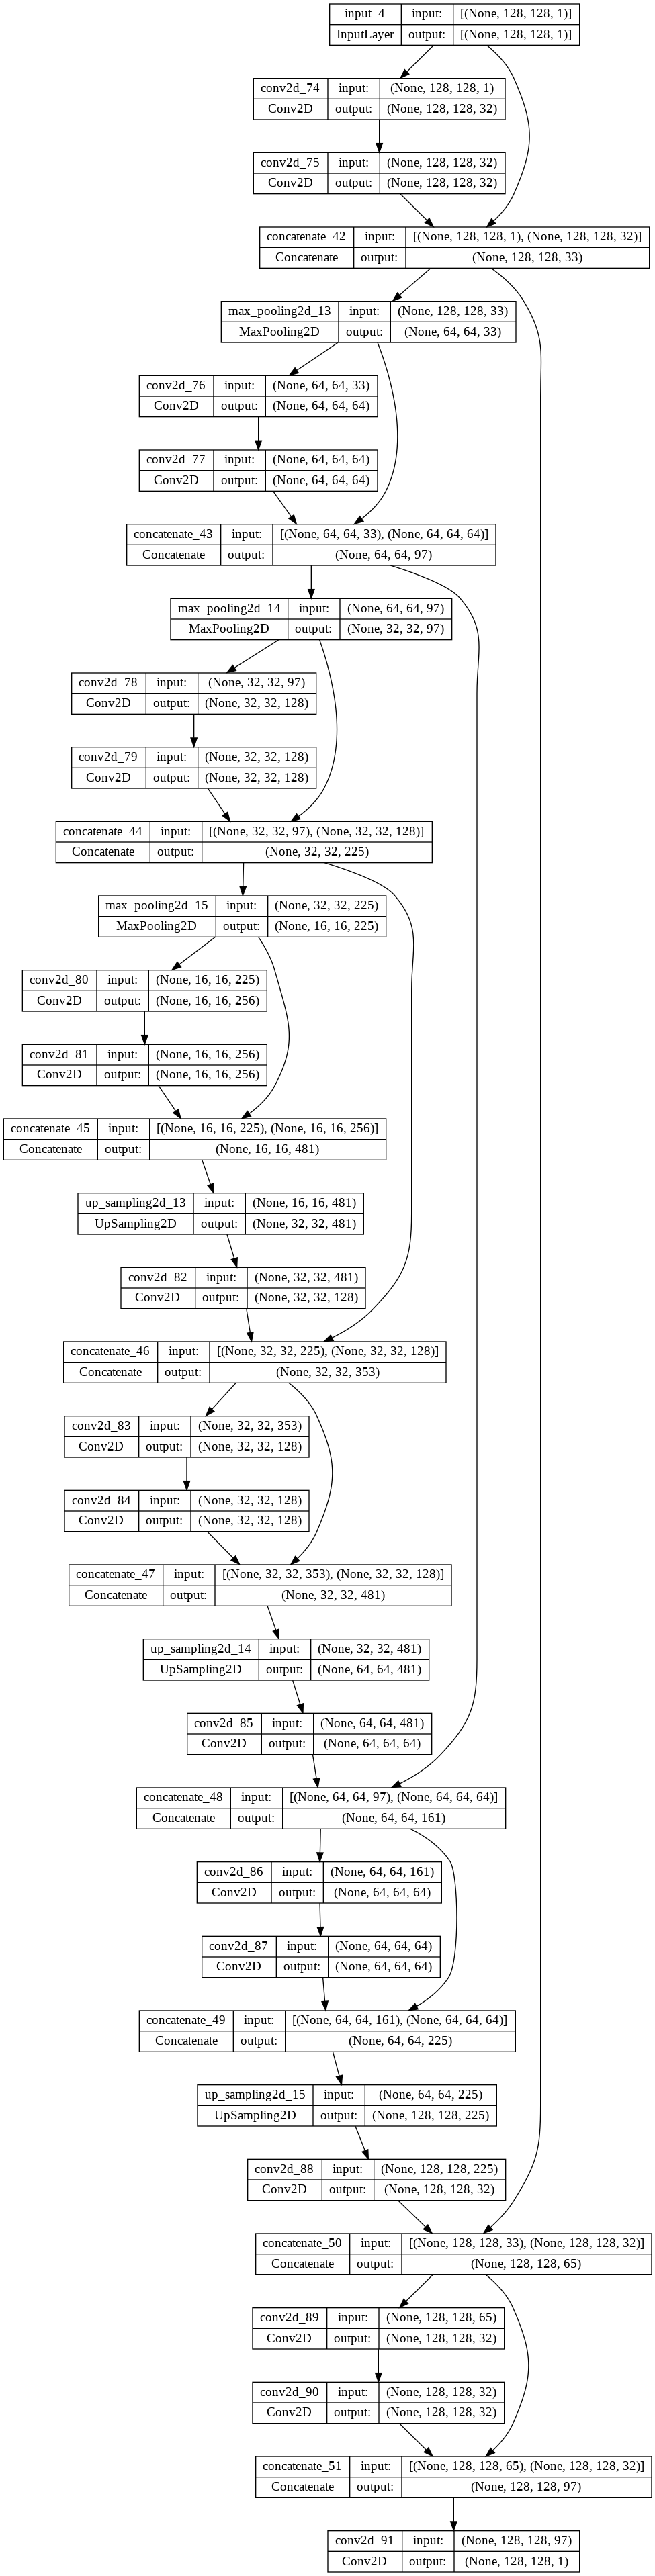

In [36]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [34]:
model.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [35]:
%%time
# hist = model.fit(datagen_train, epochs = 11, validation_data=datagen_train)
hist = model.fit(datagen, epochs = 10, validation_data=datagen_val)

Epoch 1/10
2/2 [==============================] - 66s 50s/step - loss: 0.8012 - binary_crossentropy: 0.6200 - dice_coef: 0.0177 - val_loss: 0.5799 - val_binary_crossentropy: 0.1780 - val_dice_coef: 0.0182
Epoch 2/10
2/2 [==============================] - 65s 50s/step - loss: 0.5961 - binary_crossentropy: 0.1976 - dice_coef: 0.0055 - val_loss: 0.6164 - val_binary_crossentropy: 0.2330 - val_dice_coef: 1.3031e-04
Epoch 3/10
2/2 [==============================] - 67s 52s/step - loss: 0.5767 - binary_crossentropy: 0.1536 - dice_coef: 3.2938e-04 - val_loss: 0.5505 - val_binary_crossentropy: 0.1057 - val_dice_coef: 0.0046
Epoch 4/10
2/2 [==============================] - 65s 51s/step - loss: 0.5440 - binary_crossentropy: 0.0966 - dice_coef: 0.0086 - val_loss: 0.5525 - val_binary_crossentropy: 0.1204 - val_dice_coef: 0.0154
Epoch 5/10
2/2 [==============================] - 66s 52s/step - loss: 0.5488 - binary_crossentropy: 0.1099 - dice_coef: 0.0123 - val_loss: 0.5457 - val_binary_crossentropy

1000 samples, depth of 2 and 10 training epochs need 19 minutes to run.

In [37]:
def plotHistory(hist, title):
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.plot(hist.history['loss'], label='loss')
  plt.ylabel("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.title(title)
  plt.show

def plotDice(hist, title):
  plt.plot(hist.history['val_dice_coef'], label='val_dice_coef')
  plt.plot(hist.history['dice_coef'], label='dice_coef')
  plt.ylabel("Dice Coefficient")
  plt.xlabel("Epochs")
  plt.legend()
  plt.title(title)
  plt.show

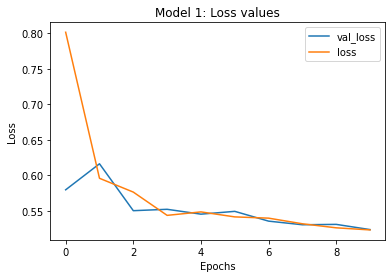

In [38]:
plotHistory(hist, "Model 1: Loss values")

As opposed to earlier, we can now see that the loss function decreases. There is also clearly no overfitting, as has about the same values for the val_loss and normal loss. 

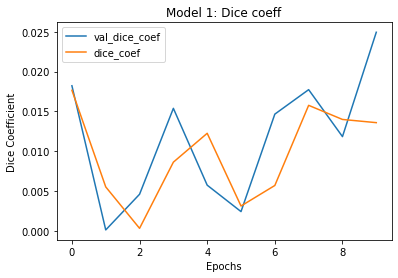

In [40]:
plotDice(hist, "Model 1: Dice coeff")

On the other hand, the dice coeffiecient does not change a lot. It is even lower than achieved in the last model in the other notebook, reaching a score of 0.025. 

In [39]:
preds = model.predict(datagen_val)

9/9 [==============================] - 39s 4s/step


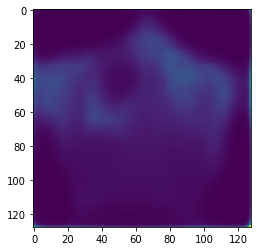

In [42]:
plt.imshow(preds[7].reshape(128,128))

The low dice coefficient is also seen in the prediction, as it does not provide a good example. 

## Conclusion

As seen in the section above, the new updates does not provide a sufficient increase in the time needed to train the models. Achieving a dice coefficient of 0.025 requires 20 minutes of training time - a satisfying score would therefore need more computing power than available in the google colab notebook (or on my computer). Therefore no further tuning is tested on this either. 


